In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
from ROI_extraction import DataGenerator
# Set the path to dataset
dataset_path = '../images/3regimes'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':-1}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# # Shuffle the list of tuples
# random.shuffle(ids)

# # Define the split ratio (e.g., 80% for training, 20% for validation)
# split_ratio = 0.8

# # Calculate the index for splitting
# split_index = int(len(ids) * split_ratio)

# # Split the shuffled IDs and labels into training and validation sets
# train_ids = ids[:split_index]
# val_ids = ids[split_index:]

In [3]:
def correct_gamma(image):
    # Convert image to float and normalize to range 0-1
    image_normalized = image.astype(float) / 255.0

    # Calculate mean R intensity
    meanRimg = np.mean(image_normalized[:, :, 2])  # Image is in BGR format
    
    # Calculate G value
    G = 0.74 * np.exp(-3.97 * meanRimg)
    
    # Apply transformation
    transformed_image = np.power(image_normalized, 1 / G)
    img_float32 = np.float32(transformed_image)
    return img_float32

def extract_ROI(original_image):
    # Convert to grayscale
    gray_image = cv2.cvtColor((original_image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # # Apply histogram normalization
    # normalized_image = cv2.equalizeHist(gray_image)
    
    # Apply median filtering
    filtered_image = cv2.medianBlur(gray_image, 5)
    
    # Apply Otsu's thresholding
    _, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    # Find contours in the processed image
    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Calculate the moments of the contour
    M = cv2.moments(contour)
    
    # Calculate the center of the contour
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    # Calculate the coordinates of the square ROI
    roi_size = 100
    roi_x = center_x - roi_size // 2
    roi_y = center_y - roi_size // 2
    
    return {'contours':contours,'roi_x':roi_x,'roi_y':roi_y,'roi_size':roi_size}

In [4]:
# Set the input image dimensions
img_width, img_height = 100, 100
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

In [5]:
def data_generation(list_IDs_temp):
    X = []
    y = np.empty((len(list_IDs_temp)), dtype=int)
    for i, ID in enumerate(list_IDs_temp):
        image = cv2.imread(ID)
        img_gamma_correct = correct_gamma(image)
        ROI = extract_ROI(img_gamma_correct)
        ROI = image[ROI['roi_y']:ROI['roi_y']+ROI['roi_size'], ROI['roi_x']:ROI['roi_x']+ROI['roi_size']]
        # ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
        X.append(ROI)
        # Store class
        y[i] = labels[ID]
    X = np.reshape(X,(len(list_IDs_temp),img_width, img_height,params['n_channels']))
    X = X.astype("float32") / 255.0
    return X, keras.utils.to_categorical(y, num_classes=params['n_classes'])


In [5]:
X,y = data_generation(ids)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val,
                                                    y_val,
                                                    test_size=1/3,
                                                    random_state=42)

NameError: name 'X' is not defined

In [8]:
# Create the VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, n_channels))

# Freeze the layers of the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Create the top layers for feature extraction
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model for feature extraction
model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model for feature extraction
# history = model.fit(
#     x=X_train,y=y_train,validation_data=(X_val,y_val),
#     epochs=50
# )


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [11]:
# Unfreeze the upper layers of the convolutional base
for layer in model.layers[0].layers[15:]:
    layer.trainable = True

# Compile the model for fine-tuning
model.compile(optimizer=Adam(learning_rate=5e-6), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model for fine-tuning
# history_fine_tuning = model.fit(
#     x=X_train,y=y_train,validation_data=(X_val,y_val),
#     epochs=100
# )

# Save the trained model
model.save('vgg16_model.h5')

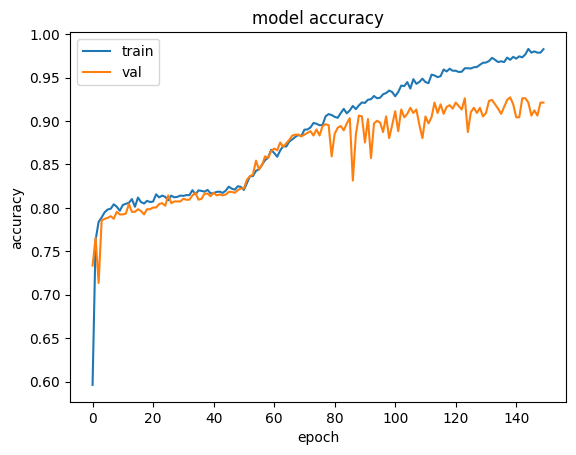

In [32]:
plt.plot(np.concatenate((history.history['accuracy'],history_fine_tuning.history['accuracy']),axis=0))
plt.plot(np.concatenate((history.history['val_accuracy'],history_fine_tuning.history['val_accuracy']),axis=0))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

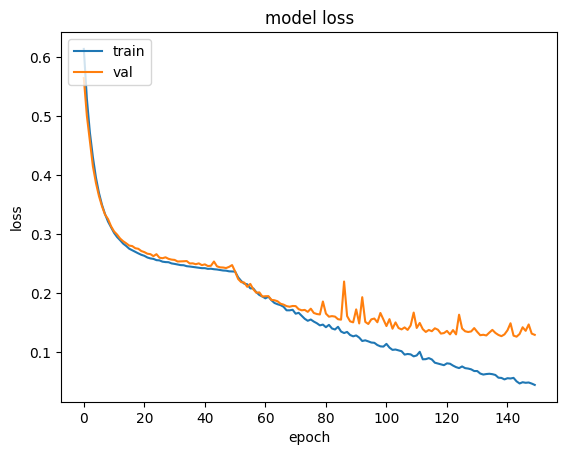

In [35]:
plt.plot(np.concatenate((history.history['loss'],history_fine_tuning.history['loss']),axis=0))
plt.plot(np.concatenate((history.history['val_loss'],history_fine_tuning.history['val_loss']),axis=0))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 3s 202ms/step - loss: 0.1328 - accuracy: 0.9082


[0.13283532857894897, 0.9081836342811584]

In [33]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 5,900,291
Non-trainable params: 9,995,072
_________________________________________________________________


In [10]:
# import os
# import random
# # Define the path to dataset folder
# folder_path = '../images/3regimes/excess'

# # Collect the paths of all image files in the folder
# image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith((".jpg", ".jpeg", ".png"))]

# # Create a subplot grid for 10 images
# fig, axes = plt.subplots(2, 5, figsize=(12, 6))
# axes = axes.ravel()

# random_numbers = []
# for _ in range(10):
#     random_numbers.append(random.randint(0, len(image_paths)))

# for i,index in enumerate(random_numbers):
#     print(index)
#     axes[i].imshow(cv2.cvtColor(preprocess_image(cv2.imread(image_paths[index])), cv2.COLOR_BGR2RGB))
#     axes[i].axis('off')
# plt.tight_layout()
# plt.show()